In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pystan

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [2]:
import pymc3 as pm
import theano
import theano.tensor as T
from scipy.stats.stats import pearsonr

ERROR (theano.sandbox.cuda): Failed to compile cuda_ndarray.cu: libcublas.so.8.0: cannot open shared object file: No such file or directory
ERROR:theano.sandbox.cuda:Failed to compile cuda_ndarray.cu: libcublas.so.8.0: cannot open shared object file: No such file or directory


In [3]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [4]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser, host='/var/run/postgresql')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [5]:
query = """
SELECT * FROM icu_features
"""
ef = pd.read_sql_query(query, con)
ef.head()

,icustay_id,hadm_id,subject_id,age,gender,height,weight,ethnicity,insurance,filter_vaso,...,pc_bronch,pc_cath,pc_echo,pc_pressor,pc_rhc,pc_thora,pc_vent,passed_filters,use_record,bmi
0,200001,152234,55973,22290 days 19:06:12,F,167.851667,27.669135,ASIAN - ASIAN INDIAN,Medicare,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,9.820741
1,200003,163557,27513,17625 days 19:50:04,M,177.800000,78.224998,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,24.744692
2,200006,189514,10950,19736 days 11:28:14,M,165.100000,82.400002,OTHER,Medicaid,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.229647
3,200007,129310,20707,15818 days 10:03:37,M,177.800000,126.000000,WHITE,Private,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.857223
4,200009,129607,29904,17353 days 10:34:32,F,160.020000,85.833331,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,33.520264


In [6]:
len(ef)

61532

In [7]:
F = (ef['use_record'] == 1)

In [8]:
ef = ef.loc[F]
len(ef)

9320

In [9]:
ef.ea_lv_systolic.value_counts()

 0.0    2297
-1.0     308
 3.0     220
 1.0     183
 2.0     147
-2.0      71
-3.0      30
Name: ea_lv_systolic, dtype: int64

## Calculate MDRD and add to features table

In [10]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [11]:
value = mdrd(ef)
ef['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef['mdrd_discrete'] = discrete
discrete.value_counts()

0    2524
1    2068
2    1439
4    1280
3    1258
5     503
dtype: int64

In [12]:
discrete = pd.cut(value, [0, 30, 60, 1000000], labels=[2, 1, 0], include_lowest=True)
ef['mdrd_3'] = discrete
discrete.value_counts()

0    4592
1    2697
2    1783
dtype: int64

In [13]:
sum(np.isnan(ef.mdrd))

248

In [14]:
sum(np.isnan(ef.bmi))

3242

In [15]:
sum(np.isnan(ef.fb_day1_balance_ml))

637

In [16]:
sum(np.isnan(ef.fb_day2_balance_ml))

2041

In [17]:
sum(np.isnan(ef.fb_day3_balance_ml))

3832

In [67]:
survival_time = (ef.dod - ef.intime).astype('timedelta64[D]')
ef['survival_time'] = survival_time
ef['day30_mortality'] = survival_time <= 30

## Does creatinine missing mean the person died immediately upon ICU admission?

In [30]:
creatinine_missing = np.isnan(ef.lab_creatinine)
table = pd.DataFrame()
table['Time to death'] = (ef.dod - ef.intime).astype('timedelta64[D]')
table['Creatinine'] = creatinine_missing

In [31]:
missing = table['Time to death'].isnull()

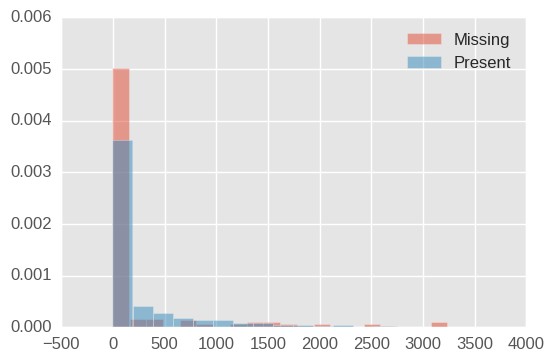

In [37]:
bins = 20
plt.hist(table['Time to death'].loc[table.Creatinine & ~missing], label='Missing', bins=bins
         , alpha=0.5, normed=True)
plt.hist(table['Time to death'].loc[~table.Creatinine & ~missing], label='Present', bins=bins
         , alpha=0.5, normed=True)
_ = plt.legend(loc='best')

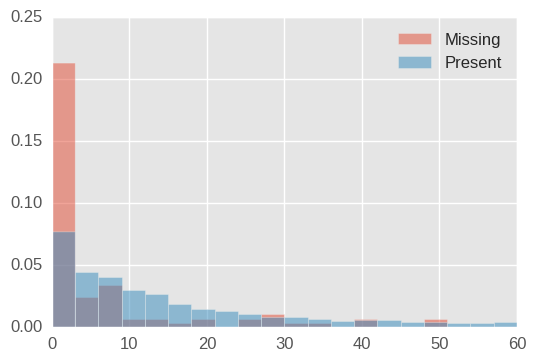

In [41]:
bins = 20
xlim = (0,60)
plt.hist(table['Time to death'].loc[table.Creatinine & ~missing], label='Missing', bins=bins
         , alpha=0.5, normed=True, range=xlim)
plt.hist(table['Time to death'].loc[~table.Creatinine & ~missing], label='Present', bins=bins
         , alpha=0.5, normed=True, range=xlim)
_ = plt.legend(loc='best')

## What time was the echo done relative to ICU admission?

In [68]:
time = (ef.ed_charttime - ef.intime).astype('timedelta64[h]')
missing = np.isnan(time)

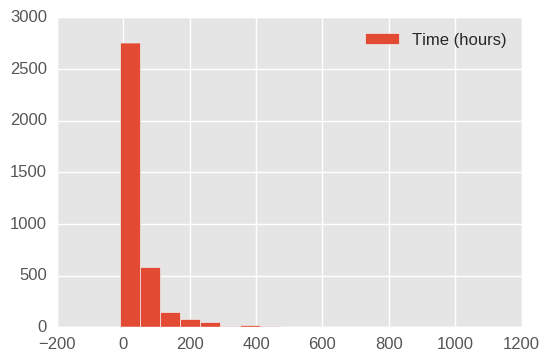

In [69]:
plt.hist(time.loc[~missing], label='Time (hours)', bins=20)
_ = plt.legend(loc='best')

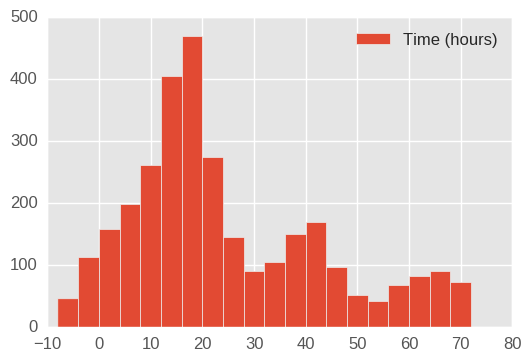

In [70]:
plt.hist(time.loc[~missing], label='Time (hours)', bins=20, range=(-8, 72))
_ = plt.legend(loc='best')

In [71]:
time[~missing].describe()

count    3686.000000
mean       48.950353
std        78.896755
min        -8.000000
25%        13.000000
50%        22.000000
75%        54.000000
max      1196.000000
dtype: float64

In [72]:
echo_within_24h = time <= 24
ef['echo_within_24h'] = echo_within_24h

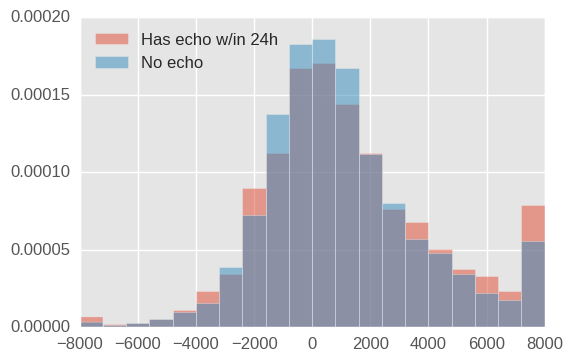

In [73]:
table = ef.loc[~np.isnan(ef.fb_day1_balance_ml)]
bins = 20
_ = plt.hist(table.fb_day1_balance_ml.loc[table.echo_within_24h], label='Has echo w/in 24h', alpha=0.5, normed=True
            , bins=bins)
_ = plt.hist(table.fb_day1_balance_ml.loc[~table.echo_within_24h], label='No echo', alpha=0.5, normed=True
            , bins=bins)
_ = plt.legend(loc='best')

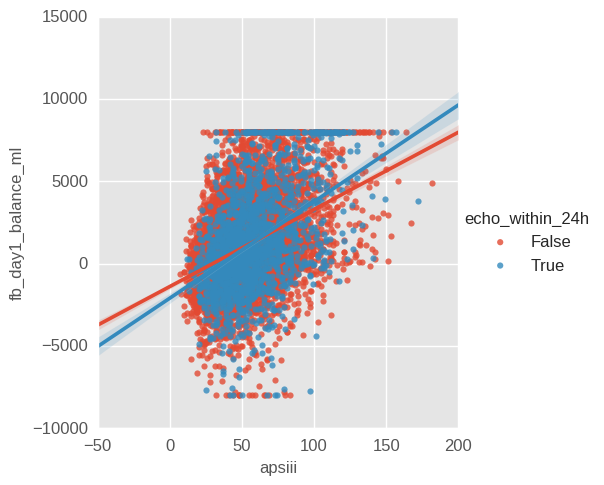

In [74]:
sns.lmplot(x='apsiii', y='fb_day1_balance_ml', hue='echo_within_24h', data=table)

In [75]:
pearsonr(table.apsiii, table.fb_day1_balance_ml)

(0.39945673446983293, 0.0)

In [76]:
for value in table.echo_within_24h.unique():
    part = table.loc[table.echo_within_24h == value]
    print(value, pearsonr(part.apsiii, part.fb_day1_balance_ml))

True (0.44295002828912694, 1.6402608907783988e-90)
False (0.38517065069726819, 5.6607103980015674e-240)


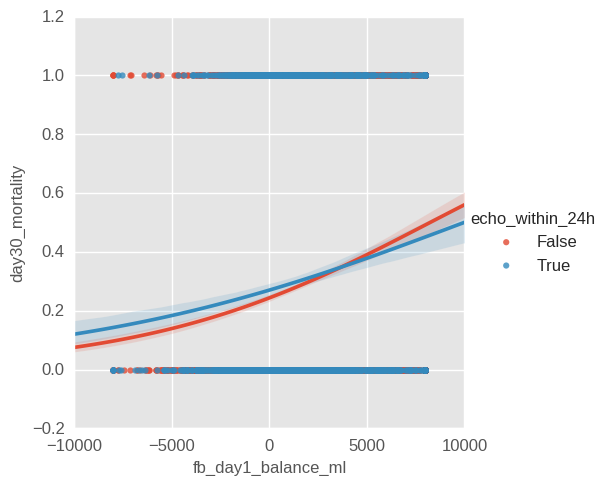

In [79]:
sns.lmplot(x='fb_day1_balance_ml', y='day30_mortality', hue='echo_within_24h', data=table, logistic=True)

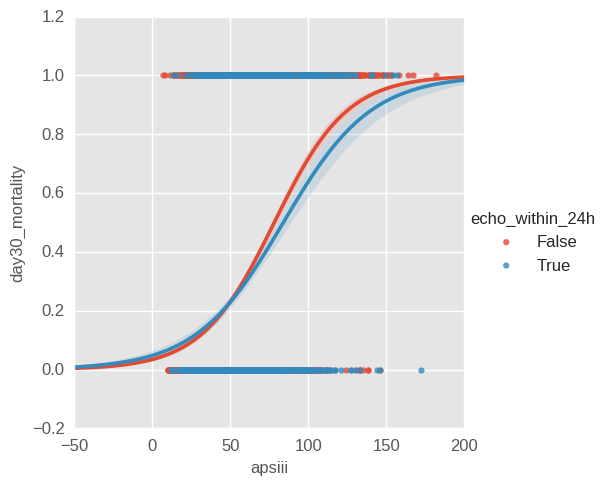

In [80]:
sns.lmplot(x='apsiii', y='day30_mortality', hue='echo_within_24h', data=table, logistic=True)

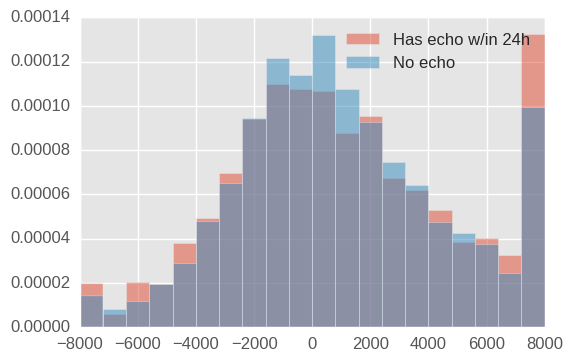

In [81]:
table = ef.loc[~np.isnan(ef.fb_day2_balance_ml)]
bins = 20
_ = plt.hist(table.fb_day2_balance_ml.loc[table.echo_within_24h], label='Has echo w/in 24h', alpha=0.5, normed=True
            , bins=bins)
_ = plt.hist(table.fb_day2_balance_ml.loc[~table.echo_within_24h], label='No echo', alpha=0.5, normed=True
            , bins=bins)
_ = plt.legend(loc='best')

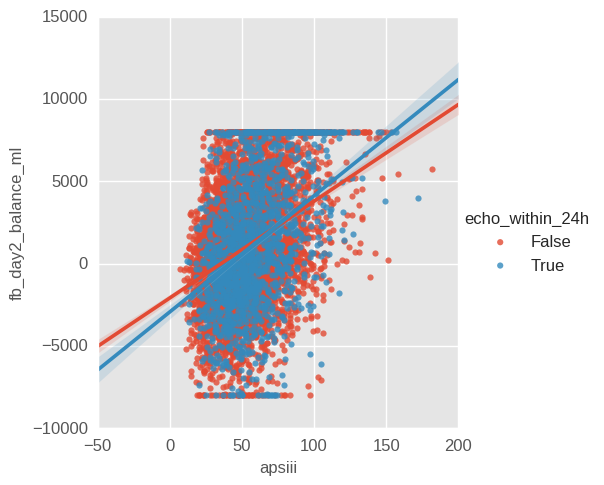

In [82]:
sns.lmplot(x='apsiii', y='fb_day2_balance_ml', hue='echo_within_24h', data=table)

In [83]:
pearsonr(table.apsiii, table.fb_day2_balance_ml)

(0.3603822560703161, 3.8100939319843402e-222)

In [84]:
for value in table.echo_within_24h.unique():
    part = table.loc[table.echo_within_24h == value]
    print(value, pearsonr(part.apsiii, part.fb_day2_balance_ml))

True (0.39753987386673661, 1.2478790153186421e-63)
False (0.34885821988070442, 8.8753197452339518e-161)


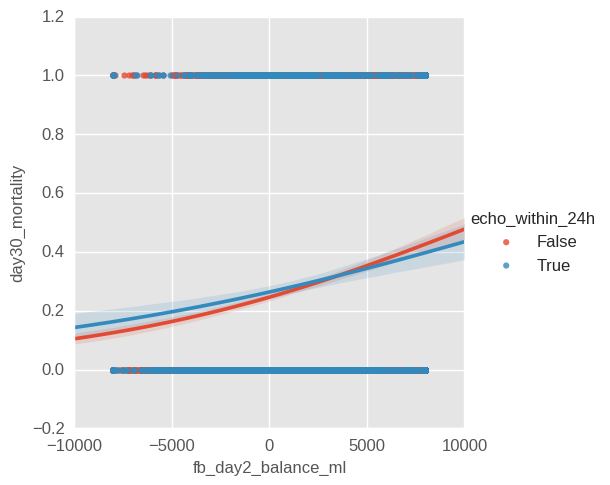

In [85]:
sns.lmplot(x='fb_day2_balance_ml', y='day30_mortality', hue='echo_within_24h', data=table, logistic=True)

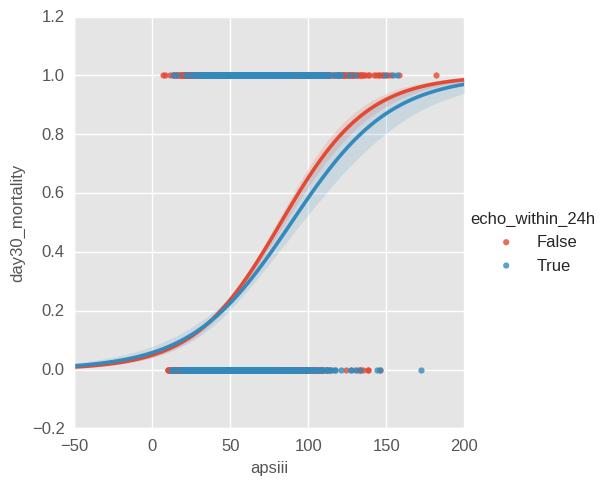

In [86]:
sns.lmplot(x='apsiii', y='day30_mortality', hue='echo_within_24h', data=table, logistic=True)